#Face detector
Store the face images to drive

In [ ]:
!pip install facenet-pytorch

from facenet_pytorch import MTCNN, extract_face
import matplotlib.image as mpl
import matplotlib.pyplot as plt
import os
import cv2
import numpy as np
import glob

mtcnn = MTCNN()

     |████████████████████████████████| 1.9MB 3.7MB/s 


In [ ]:
#Set the paths
path = '/content/drive/MyDrive/Task_1/development/real_kaggle/'
face_path = '/content/drive/MyDrive/Task_1/development_face/real/'



In [ ]:
#Counter
it=0
for img in glob.glob(path+"*.jpg"):
    it=it+1
    print(it)
    

    im=mpl.imread(img)

    #image height
    h= int(im.shape[0])
    #image width
    w= int(im.shape[1]) 

    #name of the new files
    #OR real.jpg
    file_name=face_path+str (it)+'real_train.jpg'


    try:
        boxes, probs = mtcnn.detect(im)
    except RuntimeError as e:
        print(f"Failed to detected image {im_path}")
        continue
    #Detection

    

    #if there is no detection, save the original image
    if boxes is None:
      #mpl.imsave(file_name, im)
      print("there is one image, where there is no detection..")
      continue;


    #We will consider just one detection with the biggest height (which is most likely the sought human face)
    biggest_y=0
    

    for box, prob in zip(boxes, probs):
          startX, startY, endX, endY = box.astype(int)
          if endY-startY>biggest_y:
            biggest_y=endY-startY
            biggest_blob=box

    #we might want to detect bigger rectangle than the output of face detector, CAN BE CHANGED!!
    bias=30

    #The biggest blob
    startX, startY, endX, endY = biggest_blob.astype(int)



    #Visualize, do not use it if you want to save the images
    #color = (0,255,0) 
    #cv2.rectangle(im, (startX-bias, startY-bias), (endX+bias, endY+bias), color, 2) 

    #plotting, for visualization
    #plt.imshow(im)
    #plt.show()

    #Checking boundaries, it is important, trust me
    start_x=np.max(np.array([0, startX-bias]))
    start_y=np.max(np.array([0, startY-bias]))
    end_x=np.min(np.array([endX+bias, w]))
    end_y=np.min(np.array([endY+bias, h]))

    #Cropping and saving
    face_img=im[start_y:end_y, start_x:end_x]
    mpl.imsave(file_name, face_img)




#Defining an importan function for feature extraction

In [ ]:
import numpy as np

def azimuthalAverage(image, center=None):
    """
    Calculate the azimuthally averaged radial profile.
    image - The 2D image
    center - The [x,y] pixel coordinates used as the center. The default is 
             None, which then uses the center of the image (including 
             fracitonal pixels).
    
    """
    # Calculate the indices from the image
    y, x = np.indices(image.shape)

    if not center:
        center = np.array([(x.max()-x.min())/2.0, (y.max()-y.min())/2.0])

    r = np.hypot(x - center[0], y - center[1])

    # Get sorted radii
    ind = np.argsort(r.flat)
    r_sorted = r.flat[ind]
    i_sorted = image.flat[ind]

    # Get the integer part of the radii (bin size = 1)
    r_int = r_sorted.astype(int)

    # Find all pixels that fall within each radial bin.
    deltar = r_int[1:] - r_int[:-1]  # Assumes all radii represented
    rind = np.where(deltar)[0]       # location of changed radius
    nr = rind[1:] - rind[:-1]        # number of radius bin
    
    # Cumulative sum to figure out sums for each radius bin
    csim = np.cumsum(i_sorted, dtype=float)
    tbin = csim[rind[1:]] - csim[rind[:-1]]

    radial_prof = tbin / nr

    return radial_prof

In [ ]:
import glob
import numpy as np

rootdir = '/content/drive/MyDrive/Task_1/development_face/real/'

a=np.shape(glob.glob(rootdir+"*.jpg"))[0]
print(a)

1075


#Feature extraction for the training set



In [ ]:

import cv2
import numpy as np
import os
import glob
from matplotlib import pyplot as plt
import pickle
from scipy.interpolate import griddata

data= {}
epsilon = 1e-8
N = 300
y = []
error = []




psd1D_org_mean = np.zeros(N)
psd1D_org_std = np.zeros(N)


cont = 0

#fake data
rootdir = '/content/drive/MyDrive/Task_1/development_face/fake/'

#Number of the images
number_iter = np.shape(glob.glob(rootdir+"*.jpg"))[0]

#Features
psd1D_total = np.zeros([number_iter, N])
label_total = np.zeros([number_iter])

for filename in glob.glob(rootdir+"*.jpg"):
    img = cv2.imread(filename,0)
    
    f = np.fft.fft2(img)
    fshift = np.fft.fftshift(f)
    fshift += epsilon
    
    magnitude_spectrum = 20*np.log(np.abs(fshift))
    psd1D = azimuthalAverage(magnitude_spectrum)

    # Calculate the azimuthally averaged 1D power spectrum
    points = np.linspace(0,N,num=psd1D.size) # coordinates of a
    xi = np.linspace(0,N,num=N) # coordinates for interpolation

    interpolated = griddata(points,psd1D,xi,method='cubic')
    interpolated /= interpolated[0]

    psd1D_total[cont,:] = interpolated             
    label_total[cont] = 1
    cont+=1

    if cont == number_iter:
        break

for x in range(N):
    psd1D_org_mean[x] = np.mean(psd1D_total[:,x])
    psd1D_org_std[x]= np.std(psd1D_total[:,x])
    

## real data


psd1D_org_mean2 = np.zeros(N)
psd1D_org_std2 = np.zeros(N)

cont = 0
rootdir2 = '/content/drive/MyDrive/Task_1/development_face/real/'

#Number of the images
number_iter = np.shape(glob.glob(rootdir2+"*.jpg"))[0]

#Features
psd1D_total2 = np.zeros([number_iter, N])
label_total2 = np.zeros([number_iter])


for filename in glob.glob(rootdir2+"*.jpg"):    
    img = cv2.imread(filename,0)

    f = np.fft.fft2(img)
    fshift = np.fft.fftshift(f)
    fshift += epsilon

    magnitude_spectrum = 20*np.log(np.abs(fshift))

    # Calculate the azimuthally averaged 1D power spectrum
    psd1D = azimuthalAverage(magnitude_spectrum)

    points = np.linspace(0,N,num=psd1D.size) # coordinates of a
    xi = np.linspace(0,N,num=N) # coordinates for interpolation

    interpolated = griddata(points,psd1D,xi,method='cubic')

    interpolated /= interpolated[0]

    psd1D_total2[cont,:] = interpolated             
    label_total2[cont] = 0
    cont+=1
    
    if cont == number_iter:
        break

for x in range(N):
    psd1D_org_mean2[x] = np.mean(psd1D_total2[:,x])
    psd1D_org_std2[x]= np.std(psd1D_total2[:,x])
    

y.append(psd1D_org_mean)
y.append(psd1D_org_mean2)
error.append(psd1D_org_std)
error.append(psd1D_org_std2)

psd1D_total_final = np.concatenate((psd1D_total,psd1D_total2), axis=0)
label_total_final = np.concatenate((label_total,label_total2), axis=0)

data["data"] = psd1D_total_final
data["label"] = label_total_final

output = open('celeba_low_1000_body.pkl', 'wb')
pickle.dump(data, output)
output.close()

print("DATA Saved")


DATA Saved


#Feature extraction for the test set


In [ ]:
import cv2
import numpy as np
import os
import glob
from matplotlib import pyplot as plt
import pickle
from scipy.interpolate import griddata


data= {}
epsilon = 1e-8
N = 300
y = []
error = []



psd1D_org_mean = np.zeros(N)
psd1D_org_std = np.zeros(N)


cont = 0

#fake data
rootdir = '/content/drive/MyDrive/Task_2_3/evaluation_face/fake/'
#rootdir = '/content/drive/MyDrive/Task_1/evaluation_face/fake/'

number_iter=np.shape(glob.glob(rootdir+"*.jpg"))[0]

#Features
psd1D_total = np.zeros([number_iter, N])
label_total = np.zeros([number_iter])


for filename in glob.glob(rootdir+"*.jpg"):
    img = cv2.imread(filename,0)
    
    f = np.fft.fft2(img)
    fshift = np.fft.fftshift(f)
    fshift += epsilon
    
    magnitude_spectrum = 20*np.log(np.abs(fshift))
    psd1D = azimuthalAverage(magnitude_spectrum)

    # Calculate the azimuthally averaged 1D power spectrum
    points = np.linspace(0,N,num=psd1D.size) # coordinates of a
    xi = np.linspace(0,N,num=N) # coordinates for interpolation

    interpolated = griddata(points,psd1D,xi,method='cubic')
    interpolated /= interpolated[0]

    psd1D_total[cont,:] = interpolated             
    label_total[cont] = 1
    cont+=1

    if cont == number_iter:
        break

for x in range(N):
    psd1D_org_mean[x] = np.mean(psd1D_total[:,x])
    psd1D_org_std[x]= np.std(psd1D_total[:,x])
    

## real data



psd1D_org_mean2 = np.zeros(N)
psd1D_org_std2 = np.zeros(N)



cont = 0
rootdir2 = '/content/drive/MyDrive/Task_2_3/evaluation_face/real/'

#Number of images
number_iter=np.shape(glob.glob(rootdir2+"*.jpg"))[0]

#Features
psd1D_total2 = np.zeros([number_iter, N])
label_total2 = np.zeros([number_iter])


for filename in glob.glob(rootdir2+"*.jpg"):     
    img = cv2.imread(filename,0)

    f = np.fft.fft2(img)
    fshift = np.fft.fftshift(f)
    fshift += epsilon

    magnitude_spectrum = 20*np.log(np.abs(fshift))

    # Calculate the azimuthally averaged 1D power spectrum
    psd1D = azimuthalAverage(magnitude_spectrum)

    points = np.linspace(0,N,num=psd1D.size) # coordinates of a
    xi = np.linspace(0,N,num=N) # coordinates for interpolation

    interpolated = griddata(points,psd1D,xi,method='cubic')

    interpolated /= interpolated[0]

    psd1D_total2[cont,:] = interpolated             
    label_total2[cont] = 0
    cont+=1
    
    if cont == number_iter:
        break

for x in range(N):
    psd1D_org_mean2[x] = np.mean(psd1D_total2[:,x])
    psd1D_org_std2[x]= np.std(psd1D_total2[:,x])
    

y.append(psd1D_org_mean)
y.append(psd1D_org_mean2)
error.append(psd1D_org_std)
error.append(psd1D_org_std2)

psd1D_total_final = np.concatenate((psd1D_total,psd1D_total2), axis=0)
label_total_final = np.concatenate((label_total,label_total2), axis=0)

data["data_test"] = psd1D_total_final
data["label_test"] = label_total_final

output = open('celeba_low_1000_test_body.pkl', 'wb')
pickle.dump(data, output)
output.close()

print("DATA Saved")

DATA Saved


#Feature extraction



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pickle

# load feature file
pkl_file = open('celeba_low_1000_body.pkl', 'rb')
data = pickle.load(pkl_file)
pkl_file.close()
X = data["data"]
y = data["label"]
print(X.shape)


pkl_file = open('celeba_low_1000_test_body.pkl', 'rb')   
data = pickle.load(pkl_file)
pkl_file.close()
X_test = data["data_test"]
y_test = data["label_test"]

print(X_test.shape)

(2035, 300)
(600, 300)


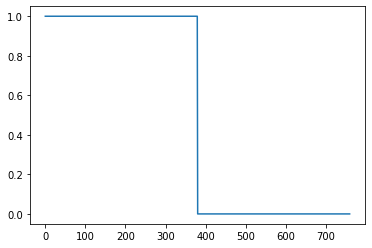

In [ ]:
plt.plot(y)

#Training and Evaluation

(600,)
(600,)
(600,)
(600,)
(600,)
(600,)
(600,)
(600,)
(600,)
(600,)
Average SVM: 0.5
Average SVM_r: 0.44333333333333336
Average SVM_p: 0.4666666666666667
Average LR: 0.41666666666666663


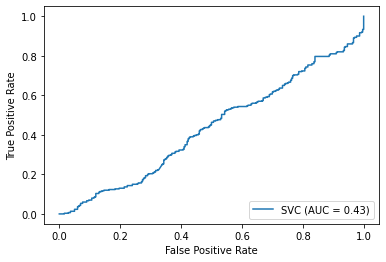

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pickle


num = 10
LR = 0
SVM = 0
SVM_r = 0
SVM_p = 0


for z in range(num):
    # read python dict back from the file
    pkl_file = open('celeba_low_1000_body.pkl', 'rb')   
    data = pickle.load(pkl_file)
    pkl_file.close()
    X_train = data["data"]
    y_train = data["label"]



    pkl_file = open('celeba_low_1000_test_body.pkl', 'rb')   
    data = pickle.load(pkl_file)
    pkl_file.close()
    X_test = data["data_test"]
    y_test = data["label_test"]

    print(y_test.shape)


    try:


        from sklearn.svm import SVC
        svclassifier = SVC(kernel='linear', probability=True)
        svclassifier.fit(X_train, y_train)
        #print('Accuracy on test set: {:.3f}'.format(svclassifier.score(X_test, y_test)))
               
        from sklearn.svm import SVC
        svclassifier_r = SVC(C=6.37, kernel='rbf', gamma=0.86)
        svclassifier_r.fit(X_train, y_train)
        #print('Accuracy on test set: {:.3f}'.format(svclassifier_r.score(X_test, y_test)))
                
        from sklearn.svm import SVC
        svclassifier_p = SVC(kernel='poly', probability=True, random_state=0)
        svclassifier_p.fit(X_train, y_train)
        #print('Accuracy on test set: {:.3f}'.format(svclassifier_p.score(X_test, y_test)))
        
        from sklearn.linear_model import LogisticRegression
        logreg = LogisticRegression(solver='liblinear', max_iter=1000)
        logreg.fit(X_train, y_train)
        #print('Accuracy on test set: {:.3f}'.format(logreg.score(X_test, y_test)))

        
        SVM+=svclassifier.score(X_test, y_test)
        SVM_r+=svclassifier_r.score(X_test, y_test)
        SVM_p+=svclassifier_p.score(X_test, y_test)
        LR+=logreg.score(X_test, y_test)

        
    except:
        num-=1
        print(num)
    
print("Average SVM: "+str(SVM/num))
print("Average SVM_r: "+str(SVM_r/num))
print("Average SVM_p: "+str(SVM_p/num))
print("Average LR: "+str(LR/num))

from sklearn.metrics import roc_curve, auc, roc_auc_score, plot_roc_curve
import matplotlib.pyplot as plt 

plot_roc_curve(svclassifier, X_test, y_test)  
plt.show()



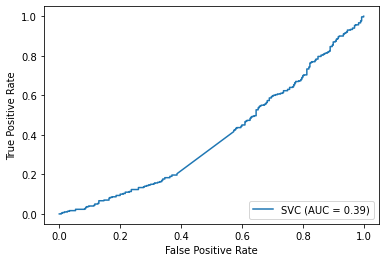

In [ ]:
from sklearn.svm import SVC
svclassifier = SVC(kernel='linear', probability=True)
svclassifier.fit(X_train, y_train)
#print('Accuracy on test set: {:.3f}'.format(svclassifier.score(X_test, y_test)))

from sklearn.metrics import roc_curve, auc, roc_auc_score, plot_roc_curve
import matplotlib.pyplot as plt 

plot_roc_curve(svclassifier, X_test, y_test)  
plt.show()


#Transfer Learning

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn.metrics as metrics

import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models

from torchvision.datasets.utils import download_file_from_google_drive
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from PIL import Image


torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [ ]:
import os
import glob
from PIL import Image
import os, os.path
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plot
import tensorflow as tf



train_transform = transforms.Compose([
    transforms.Resize(224),                                 
    transforms.RandomCrop(192),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))                  
])

valid_transform = transforms.Compose([
    transforms.Resize(224),    
    transforms.CenterCrop(192),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))                  
])

files='/content/drive/MyDrive/Task_1/development_face/'


train_set = ImageFolder(files, transform=train_transform)

print(len(train_set))

# Create an analagous ImageFolder for the validation set
files='/content/drive/MyDrive/Task_2_3/evaluation_face/'




valid_set = ImageFolder(files, transform=valid_transform)

print(len(valid_set))


train_loader = DataLoader(train_set, batch_size=64, shuffle=True)

# Create a loader for the validation set, but disable shuffling of the validation data
# (it is unnecessary to shuffle validation data)
valid_loader = DataLoader(valid_set, batch_size=64, shuffle=False)

2035
600


In [ ]:
model = models.resnet50(pretrained=True)
#model.to(device)
#print(model)

model.fc = nn.Sequential()

In [ ]:
def extract_features(loader):
    
    # put the model in eval mode
    model.eval()

    features, labels = [], []
    
    with torch.no_grad():
        for batch, targets in loader:
            #batch = batch.to(device)

            # extract the features using the model
            batch_features = model(batch)

            features.append(batch_features.data.cpu().numpy())
            labels.append(targets.numpy())

    features = np.concatenate(features, axis=0)
    labels = np.concatenate(labels, axis=0)
    return features, labels

train_features, train_labels = extract_features(train_loader)
valid_features, valid_labels = extract_features(valid_loader)

print(f'train features are {train_features.shape}')
print(f'valid features are {valid_features.shape}')

train features are (2035, 2048)
valid features are (600, 2048)


Accuracy: 0.552


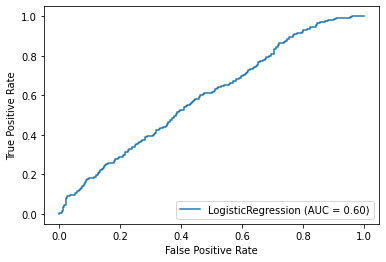

In [ ]:
from sklearn.linear_model import LogisticRegression

classifier = LogisticRegression(C=1, solver='liblinear')


# Fit the logistic regression classifier on the training features
classifier.fit(train_features, train_labels)

# make predictions using the logistic regression classifier on the validation features
y_hat = classifier.predict(valid_features)

accuracy = metrics.accuracy_score(valid_labels, y_hat)
print(f'Accuracy: {accuracy:0.3f}')


from sklearn.metrics import roc_curve, auc, roc_auc_score, plot_roc_curve
import matplotlib.pyplot as plt 

plot_roc_curve(classifier, valid_features, valid_labels)  
plt.show()

Accuracy: 0.555


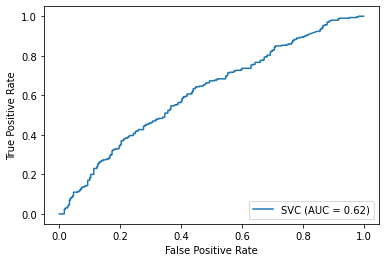

In [ ]:
from sklearn.svm import SVC

classifier = SVC(kernel='linear', probability=True)
classifier.fit(train_features, train_labels)

# make predictions
y_hat = classifier.predict(valid_features)

accuracy = metrics.accuracy_score(valid_labels, y_hat)
print(f'Accuracy: {accuracy:0.3f}')


from sklearn.metrics import roc_curve, auc, roc_auc_score, plot_roc_curve
import matplotlib.pyplot as plt 

plot_roc_curve(classifier, valid_features, valid_labels)  
plt.show()


#The mix of the two methods

Accuracy: 0.550


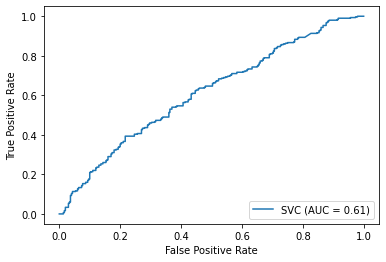

Accuracy: 0.552


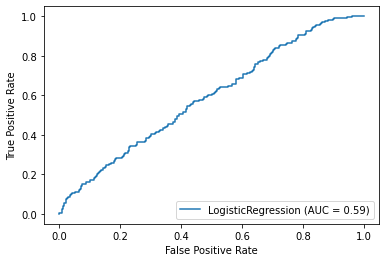

In [ ]:
#New features
train_final=np.concatenate((X_train, train_features), axis=1)
valid_final=np.concatenate((X_test, valid_features), axis=1)


##SVM

from sklearn.svm import SVC

classifier = SVC(kernel='linear', probability=True)
classifier.fit(train_final, train_labels)

# make predictions
y_hat = classifier.predict(valid_final)

accuracy = metrics.accuracy_score(valid_labels, y_hat)
print(f'Accuracy: {accuracy:0.3f}')


from sklearn.metrics import roc_curve, auc, roc_auc_score, plot_roc_curve
import matplotlib.pyplot as plt 

plot_roc_curve(classifier, valid_final, valid_labels)  
plt.show()

#LOGISTIC REGRESSION


from sklearn.linear_model import LogisticRegression

classifier = LogisticRegression(C=1, solver='liblinear')


# Fit the logistic regression classifier on the training features
classifier.fit(train_final, train_labels)

# make predictions using the logistic regression classifier on the validation features
y_hat = classifier.predict(valid_final)

accuracy = metrics.accuracy_score(valid_labels, y_hat)
print(f'Accuracy: {accuracy:0.3f}')


from sklearn.metrics import roc_curve, auc, roc_auc_score, plot_roc_curve
import matplotlib.pyplot as plt 

plot_roc_curve(classifier, valid_final, valid_labels)  
plt.show()


